# Final Project: Monocular depth

## 1. Abstract

Self-supervised single-image (monocular) depth-estimation using neural-networks

## 2. Team Members and Contributions

- Alex Wang (j2373wan@uwaterloo.ca)

- Suyeong Choi ()

- Colby Wang ()

## 3. Code Libraries

Libraries

## 4. Demo for Single Image

### Import libraries, define global

In [1]:
%matplotlib notebook
import numpy as np
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.image as image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from Unet import UNet
from loss_function import MonocularDepthLoss
from dataloader import CustomDataset

DATASET_PATH = 'dataset'
LEFT = 'image_L'
RIGHT = 'image_R'
DISPARITY = 'disparity'

image_shape = image.imread("dataset/image_L/2018-07-11-14-48-52_2018-07-11-15-09-57-367.png").shape
HEIGHT = 800
WIDTH = 1760

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read Data

In [2]:
def image_transform_single(img, height, width):
    
    # Make sure all the image sample has same size defined by (height, width) by cutting the image or filling 0s
    result = np.zeros((height, width, 3), dtype=np.float32)
    img_height = img.shape[0]
    img_width = img.shape[1]
    min_height = min(img_height, height)
    min_width = min(img_width, width)
    result[:min_height, :min_width,:] = img[:min_height, :min_width,:]
    
    # The returned value should have 3 matrices for each channel
    return np.array([result[:,:,0], result[:,:,1], result[:,:,2]])

def disparity_transform(disparity, height, width):
    result = np.zeros((height, width), dtype=np.float32)
    d_height = disparity.shape[0]
    d_width = disparity.shape[1]
    min_height = min(d_height, height)
    min_width = min(d_width, width)
    result[:min_height, :min_width] = disparity[:min_height, :min_width]
    return result

def image_transform(sample):
    result_sample = {LEFT: image_transform_single(sample[LEFT], HEIGHT, WIDTH)}
    if sample[RIGHT] is not None:
        result_sample[RIGHT] = image_transform_single(sample[RIGHT], HEIGHT, WIDTH)
        result_sample[DISPARITY] = disparity_transform(sample[DISPARITY], HEIGHT, WIDTH)
    return result_sample

In [3]:
im_left = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("images/stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col4.ppm")


### Training

Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.76it/s]

Training complete. The model should have overfit to the single image.


<IPython.core.display.Javascript object>


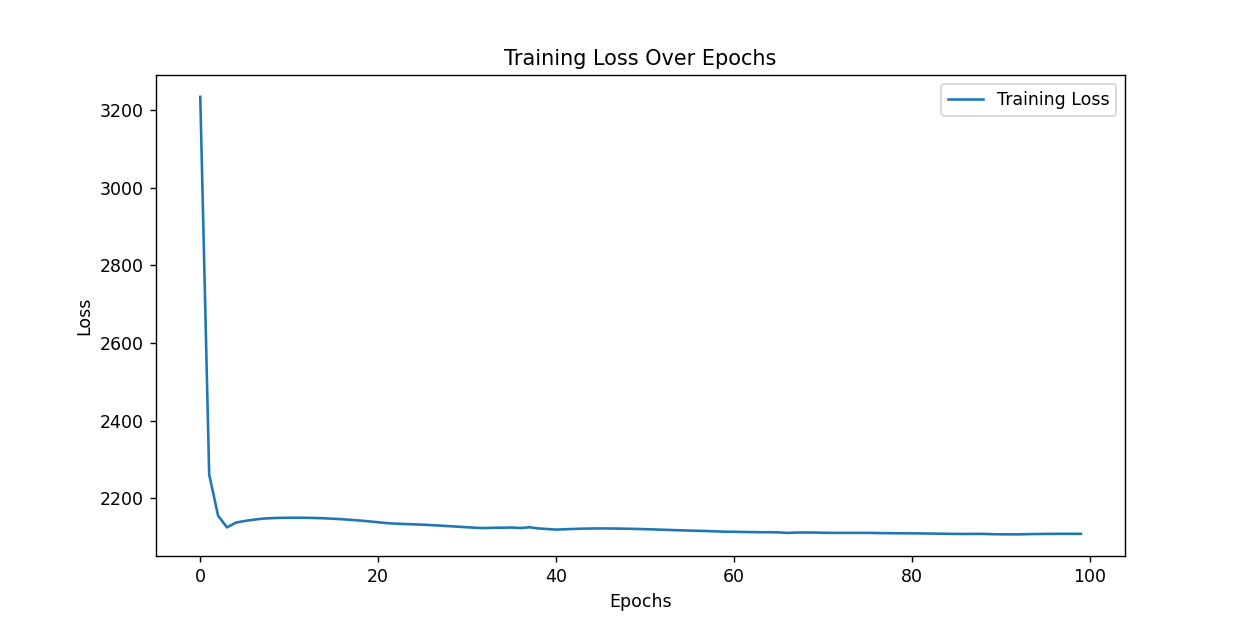

In [4]:
# Initialize the U-Net model and loss function
model = UNet()
loss_function = MonocularDepthLoss()

# Create a dummy left image and right image (single image, HWC format)
image_l = image_transform_single(im_left, im_left.shape[0], im_left.shape[1])
image_r = image_transform_single(im_right, im_right.shape[0], im_right.shape[1])
image_l = torch.from_numpy(np.expand_dims(image_l, axis=0)).to(device)
image_r = torch.from_numpy(np.expand_dims(image_r, axis=0)).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train (set high to see if it can overfit)
epochs = 100

# List to record losses
loss_history = []

# Training loop
model.to(device)
model.train()  # Set model to training mode
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    optimizer.zero_grad()

    # Forward pass
    right_disparity, left_disparity = model(image_l)

    # Calculate loss
    loss = loss_function(left_disparity, image_r, image_l, right_disparity)
    loss_history.append(loss.item())

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

print("Training complete. The model should have overfit to the single image.")

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot as a PNG file
#plt.savefig('training_loss.png')  # You can specify a different path or file name
plt.show()


### Testing

<IPython.core.display.Javascript object>


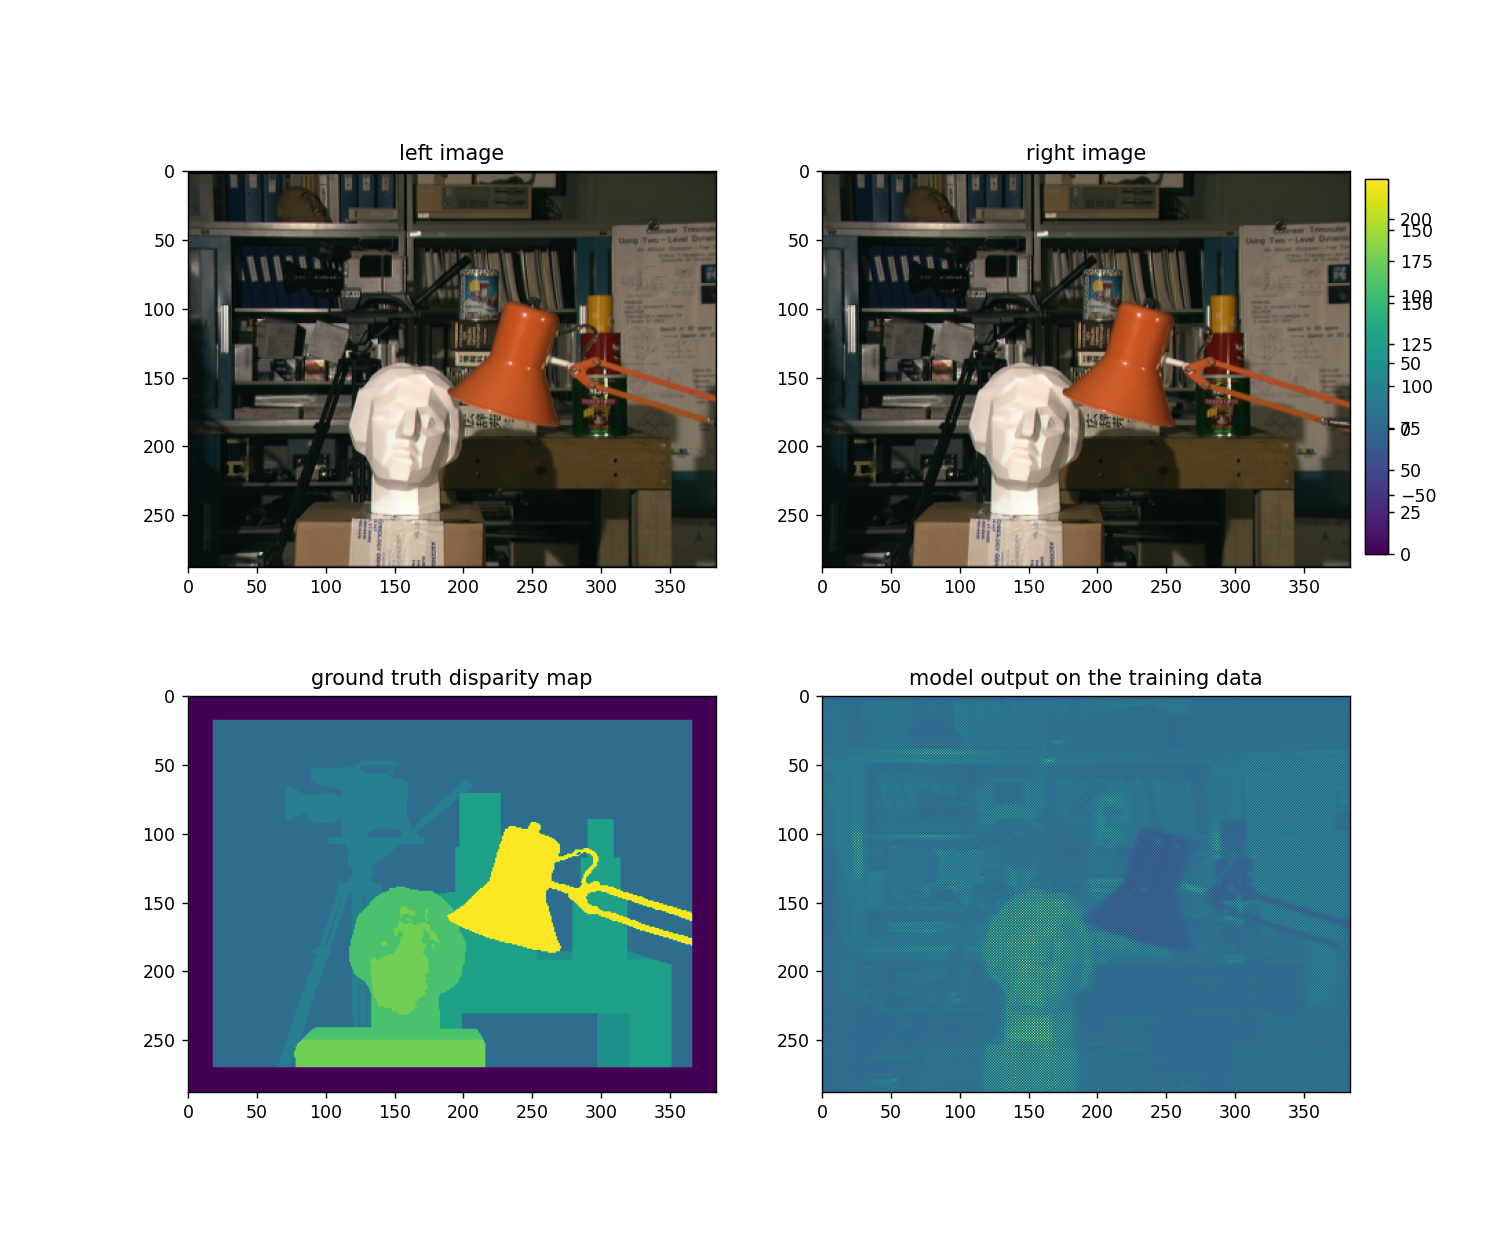

In [5]:
out_r_dmap, out_l_dmap = model(image_l)
output = out_l_dmap.detach().cpu()
output = torch.Tensor.numpy(output)
output = output.reshape(output.shape[2], output.shape[3])

fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("left image")
plt.imshow(im_left)
plt.subplot(222) 
plt.title("right image")
plt.imshow(im_right)
plt.subplot(223)
plt.title("ground truth disparity map")
plt.imshow(im_gt)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.subplot(224)
plt.title("model output on the training data")
plt.imshow(output)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.show()

## Demo for batch training

In [6]:
# # Initialize DataLoader
# training_dataset = CustomDataset(root_dir=DATASET_PATH, transform=image_transform)
# train_loader = DataLoader(training_dataset, batch_size=5, shuffle=True)  # Set a valid batch size

# # Initialize the U-Net model and loss function
# model = UNet()
# loss_function = MonocularDepthLoss()

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Number of epochs to train (set high to see if it can overfit)
# epochs = 100

# # List to record losses
# loss_history = []

# # Training Loop
# model.to(device)
# model.train() # Set model to training mode


# # Testing for 1 epoch
# # for i, sample in enumerate(train_loader):
#     # print(i)
#     # image_l = sample[LEFT].to(device)
#     # image_r = sample[RIGHT].to(device)
#     # optimizer.zero_grad()

#     # Forward pass
#     # right_disparity, left_disparity = model(image_l)

#     # Calculate loss
#     # loss = loss_function(left_disparity, image_r, image_l, right_disparity)

#     # Backward pass and optimize
#     # loss.backward()
#     # optimizer.step()




# for epoch in tqdm(range(epochs), desc="Training Epochs"):
#     epoch_loss = 0.0
#     for i, sample in enumerate(train_loader):
#         # print(i)
#         image_l = sample[LEFT].to(device)
#         image_r = sample[RIGHT].to(device)
#         optimizer.zero_grad()

#         # Forward pass
#         right_disparity, left_disparity = model(image_l)

#         # Calculate loss
#         loss = loss_function(left_disparity, image_r, image_l, right_disparity)
#         epoch_loss += loss.item()

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()
        
#     epoch_loss /= len(train_loader)
#     loss_history.append(epoch_loss)


# plt.figure(figsize=(10, 5))
# plt.plot(loss_history, label='Training Loss')
# plt.title('Training Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [7]:
model_path = 'model.pth'

# # Save the model state dictionary
# torch.save(model.state_dict(), model_path)

<IPython.core.display.Javascript object>


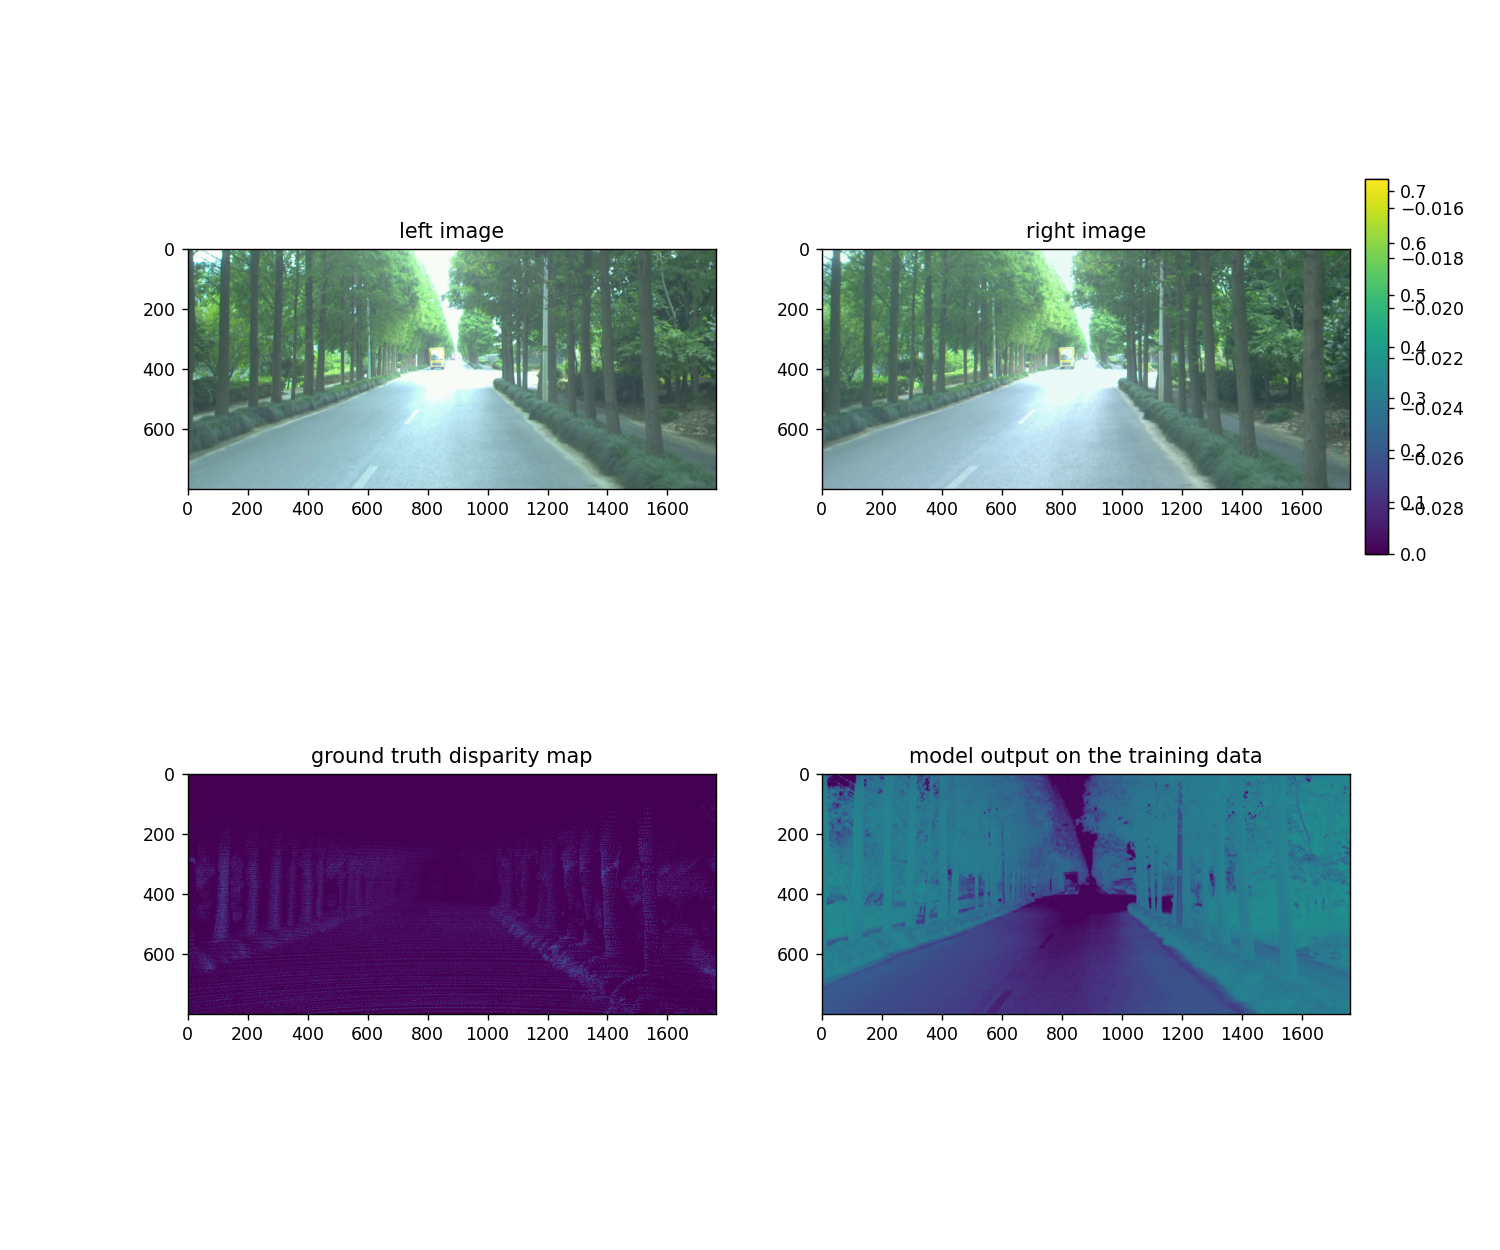

In [8]:
model = UNet()
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

im_left = image.imread("dataset/image_L/2018-07-11-14-48-52_2018-07-11-15-09-57-367.png")
im_gt = image.imread("dataset/disparity/2018-07-11-14-48-52_2018-07-11-15-09-57-367.png")
im_right = image.imread("dataset/image_R/2018-07-11-14-48-52_2018-07-11-15-09-57-367.png")

image_l = image_transform_single(im_left, 800, 1760)
image_r = image_transform_single(im_right, 800, 1760)
image_l = torch.from_numpy(np.expand_dims(image_l, axis=0)).to(device)
image_r = torch.from_numpy(np.expand_dims(image_r, axis=0)).to(device)

out_r_dmap, out_l_dmap = model(image_l)
output = out_l_dmap.detach().cpu()
output = torch.Tensor.numpy(output)
output = output.reshape(output.shape[2], output.shape[3])

fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("left image")
plt.imshow(im_left)
plt.subplot(222) 
plt.title("right image")
plt.imshow(im_right)
plt.subplot(223)
plt.title("ground truth disparity map")
plt.imshow(im_gt)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.subplot(224)
plt.title("model output on the training data")
plt.imshow(output)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.show()

# Conclusions

conclusions